# "지하철 이용승객 분석" EDA 프로젝트(1)
- 이번 프로젝트에서는 EDA가 무엇이고 , 실습을 통해 EDA 하는 방법을 배워보겠습니다.
- EDA(Exploratory Data Analysis 탐색적 데이터 분석)는 데이터를 이해하는 과정이며 
- 통계적 요약, 분포 파악 및 시각화 등의 기법을 통해 직관적으로 데이터 특성 파악 할수 있습니다.
- 결국, EDA를 통해 데이터에서 트랜드 분석, 인사이트 도출하게 됩니다. 


## EDA 실습을 통해 해결해야 할 질문들
 
- 2019.01~06 중에 언제 지하철을 가장 많이 이용했을까? (기준: 승하자총승객수)
- 1월~6월중에 5월에 지하철 승객수가 많다? (기준 :승하자총승객수)
- 요일중에서 목요일에 지하철 승객수가 많다? (기준 :승하자총승객수)
- 일자별(월일별) 승하차승객수 그래프 그려 볼까요? (기준 :승하자총승객수)
- 가장 승객이 많이 타는 승차역은?
- 노선별로 역별/요일별 승차승객수를 비교해 볼수 있을까? (1~9호선, 역별/요일별 heatmap)
- 1호선에서 가장 하자를 많이 하는 역은? (groupby)
- 2호선중에서 어느 역에서 승차가 가장 많이 발생할까? (Folium 역 표시)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pathlib import Path
import numpy as np
from matplotlib import font_manager, rc
font_path = "c:\WINDOWS\Fonts\GULIM.TTC"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.rc('font', size=8)

# 파일 관리 

In [2]:
def concat_dfs(folder_path:str , number:int = 1) -> pd.DataFrame:
    '''
    CSV 파일들이 담겨있는 절대 경로를 str 형태로 입력
    Path로 변형한 뒤 폴더 내에 있는 모든 CSV 파일들을 리스트로 표현
    number째 까지 데이터프레임을 concat 하기
    '''
    if Path.is_dir(Path(folder_path)): # 폴더명이 존재
        final = pd.DataFrame()
        folder_path = list(Path(folder_path).glob('*.csv'))
        for df_path in folder_path[:number]:
            temp = pd.read_csv(df_path)
            final = pd.concat([final,temp],ignore_index=True)
        return final
    else: # 폴더명이 존재하지 않음
        print('폴더명이 잘못되었습니다. 다시 입력해주세요.')

In [3]:
dataframe = concat_dfs(r'C:\Users\hyssk\OneDrive\바탕 화면\EDA_AI+X\실습\rawfiles',6)

# 2019.01~06 중에 언제 지하철을 가장 많이 이용했을까? (기준: 승하자총승객수)

## 사용일자, 등록일자 칼럼을 to_datetime으로 변경

In [4]:
dataframe['사용일자'] = pd.to_datetime(dataframe['사용일자'], format='%Y%m%d')
dataframe['등록일자'] = pd.to_datetime(dataframe['등록일자'], format='%Y%m%d')
dataframe

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자
0,2019-01-01,2호선,을지로4가,3862.0,3728.0,2019-01-04
1,2019-01-01,3호선,을지로3가,8104.0,7554.0,2019-01-04
2,2019-01-01,2호선,을지로입구,22478.0,21330.0,2019-01-04
3,2019-01-01,2호선,시청,8381.0,6049.0,2019-01-04
4,2019-01-01,6호선,동묘앞,8045.0,8504.0,2019-01-04
...,...,...,...,...,...,...
107023,2019-06-30,7호선,마들,6622.0,6116.0,2019-07-03
107024,2019-06-30,4호선,노원,14071.0,14702.0,2019-07-03
107025,2019-06-30,7호선,중계,9516.0,8981.0,2019-07-03
107026,2019-06-30,7호선,하계,11645.0,11121.0,2019-07-03


In [5]:
dataframe['월일'] = dataframe['사용일자'].dt.strftime('%m-%d')
dataframe['연월'] = dataframe['사용일자'].dt.strftime('%Y-%m')
dataframe['요일'] = dataframe['사용일자'].dt.dayofweek

In [6]:
dataframe['요일'] = dataframe['요일'].map({0: '월',
                        1:'화',
                        2:'수',
                        3:'목',
                        4:'금',
                        5:'토',
                        6:'일'})

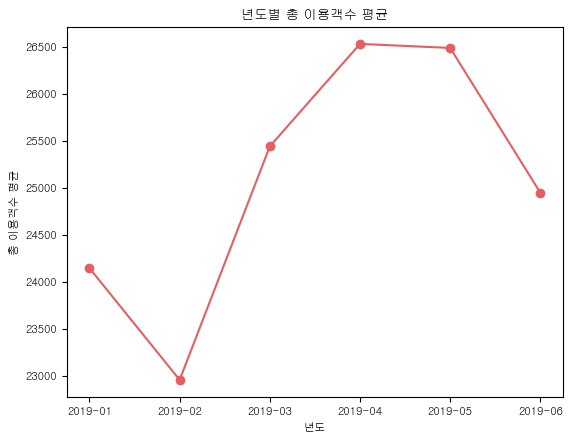

In [7]:
dataframe['총 이용객수'] = dataframe['승차총승객수'] + dataframe['하차총승객수']
q_1=dataframe.groupby('연월').mean()['총 이용객수']
plt.figure()
plt.scatter(q_1.index,q_1.values,color='#e35f62')
plt.plot(q_1.index,q_1.values,color='#e35f62')
plt.xlabel('년도')
plt.ylabel('총 이용객수 평균')
plt.title('년도별 총 이용객수 평균')
plt.show()

2019.01~06 중에 언제 지하철을 가장 많이 이용했을까? (기준: 승하자총승객수)

- 4월에 가장 많이 이용했음을 알 수 있다.


# 요일 중에서 목요일에 지하철 승객수가 많다


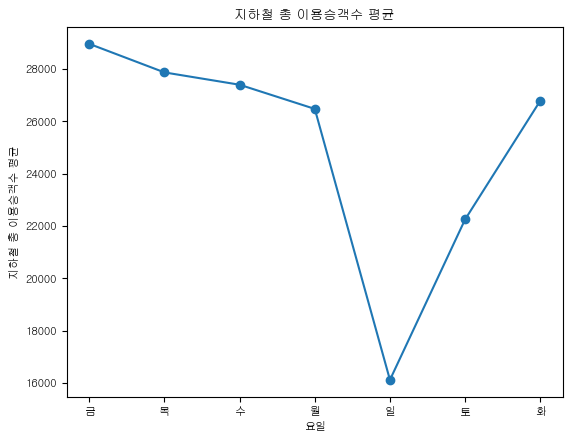

In [8]:
df_2=dataframe.groupby('요일').mean()[['총 이용객수']]
plt.figure()
plt.scatter(df_2.index,df_2.values)
plt.xlabel("요일")
plt.ylabel("지하철 총 이용승객수 평균")
plt.title("지하철 총 이용승객수 평균")
plt.plot(df_2.index,df_2.values)
plt.show()

# 연월 각각에 대해 일자별(월일별) 승하차총승객수 그래프 (PointPlot)


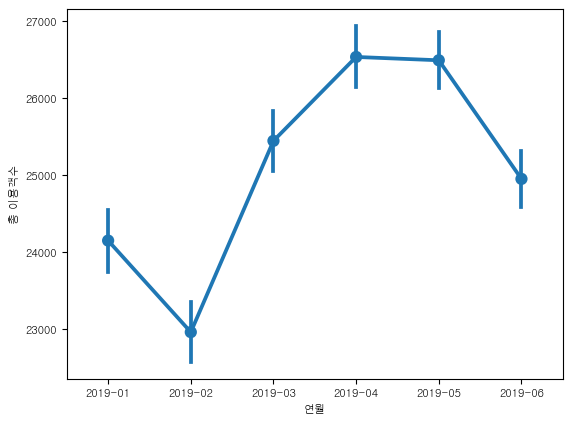

In [9]:
plt.figure()
sns.pointplot(dataframe,x='연월',y='총 이용객수')
plt.show()

# 가장 승객이 많이 타는 승차역은?

In [10]:
df_3 = dataframe.groupby('역명').mean()[['승차총승객수']]
df_3[df_3['승차총승객수']> 100000]

,승차총승객수
역명,
강남,100265.325967


강남역

# 노선별로 역별/요일별 승차 승객수를 비교해볼 수 있을까? (1~9호선, 역별/요일별 heatmap)

## 호선 , 요일별

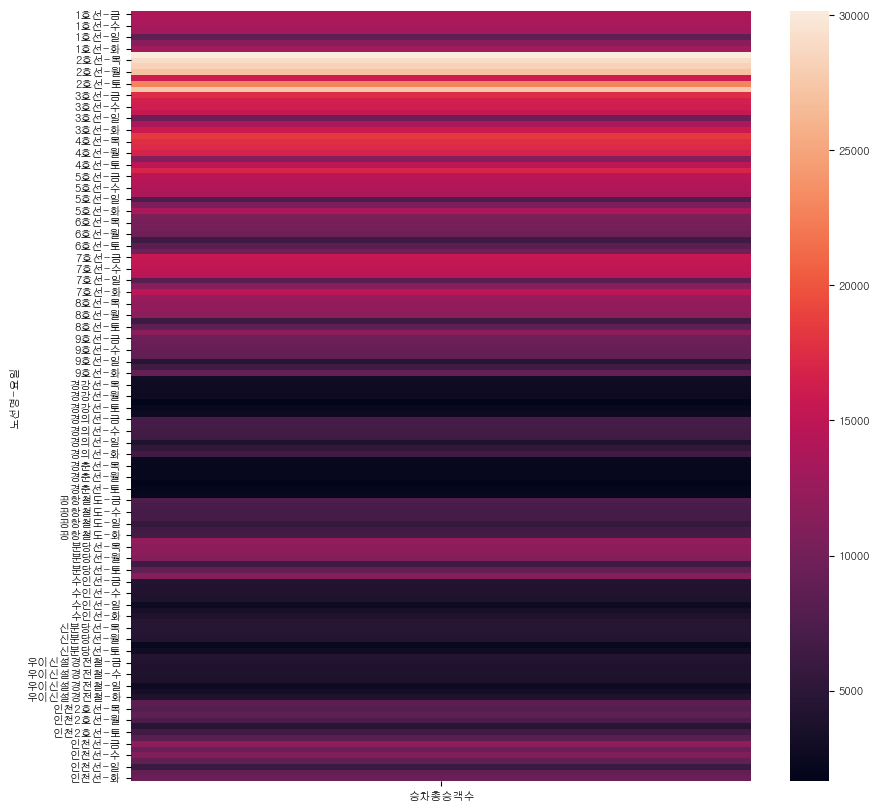

In [11]:
df_3 = dataframe.groupby(['노선명','요일']).mean()[['승차총승객수']]
plt.figure(figsize=(10,10))
sns.heatmap(df_3)
plt.show()

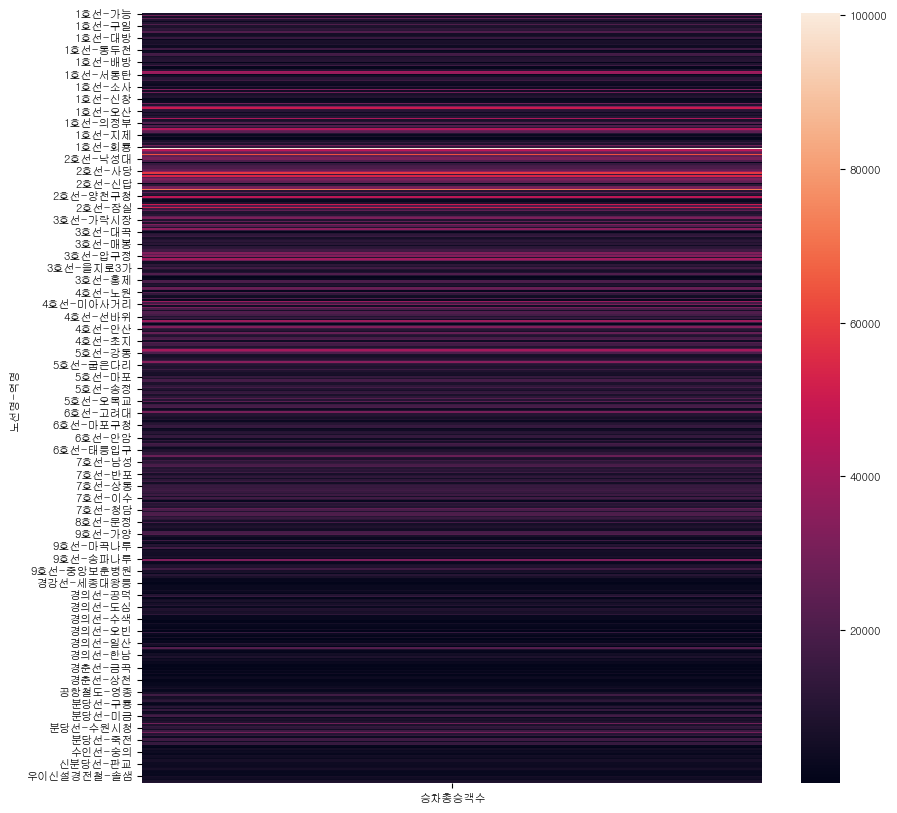

In [12]:
df_4 = dataframe.groupby(['노선명','역명']).mean()[['승차총승객수']]
plt.figure(figsize=(10,10))
sns.heatmap(df_4)
plt.show()

# 1호선에서 가장 하차를 많이하는 역은? (groupby)


In [13]:
dataframe[dataframe['노선명']=='1호선']

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자,월일,연월,요일,총 이용객수
6,2019-01-01,1호선,제기동,10187.0,10178.0,2019-01-04,01-01,2019-01,화,20365.0
7,2019-01-01,1호선,신설동,6832.0,6930.0,2019-01-04,01-01,2019-01,화,13762.0
9,2019-01-01,1호선,종로5가,13578.0,13282.0,2019-01-04,01-01,2019-01,화,26860.0
10,2019-01-01,1호선,종각,20944.0,16658.0,2019-01-04,01-01,2019-01,화,37602.0
52,2019-01-01,1호선,신설동,2525.0,2197.0,2019-01-04,01-01,2019-01,화,4722.0
...,...,...,...,...,...,...,...,...,...,...
106862,2019-06-30,1호선,신창,1146.0,1357.0,2019-07-03,06-30,2019-06,일,2503.0
106919,2019-06-30,1호선,인천,1231.0,1972.0,2019-07-03,06-30,2019-06,일,3203.0
106946,2019-06-30,1호선,신길,1713.0,1890.0,2019-07-03,06-30,2019-06,일,3603.0
107016,2019-06-30,1호선,석계,8307.0,8061.0,2019-07-03,06-30,2019-06,일,16368.0


In [14]:
df_5=dataframe[dataframe['노선명']=='1호선'] # 노선명이 1호선인 dataframe 추출
df_5= df_5.groupby('역명').mean()[['하차총승객수']]
df_5[df_5['하차총승객수'] == df_5['하차총승객수'].max()] # 하차를 가장 많이 하는 역?

,하차총승객수
역명,
영등포,52110.867403


In [15]:
dataframe

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자,월일,연월,요일,총 이용객수
0,2019-01-01,2호선,을지로4가,3862.0,3728.0,2019-01-04,01-01,2019-01,화,7590.0
1,2019-01-01,3호선,을지로3가,8104.0,7554.0,2019-01-04,01-01,2019-01,화,15658.0
2,2019-01-01,2호선,을지로입구,22478.0,21330.0,2019-01-04,01-01,2019-01,화,43808.0
3,2019-01-01,2호선,시청,8381.0,6049.0,2019-01-04,01-01,2019-01,화,14430.0
4,2019-01-01,6호선,동묘앞,8045.0,8504.0,2019-01-04,01-01,2019-01,화,16549.0
...,...,...,...,...,...,...,...,...,...,...
107023,2019-06-30,7호선,마들,6622.0,6116.0,2019-07-03,06-30,2019-06,일,12738.0
107024,2019-06-30,4호선,노원,14071.0,14702.0,2019-07-03,06-30,2019-06,일,28773.0
107025,2019-06-30,7호선,중계,9516.0,8981.0,2019-07-03,06-30,2019-06,일,18497.0
107026,2019-06-30,7호선,하계,11645.0,11121.0,2019-07-03,06-30,2019-06,일,22766.0


In [16]:
import folium
geo_dataframe = pd.read_csv(r'C:\Users\hyssk\OneDrive\바탕 화면\EDA_AI+X\실습\rawfiles\지하철노선위경도정보2.csv')
geo_dataframe=geo_dataframe.rename(columns={'호선':'노선명','역이름':'역명'})

merged_dataframe = pd.merge(dataframe,geo_dataframe,how='inner') # 위도 경도가 포함된 데이터프레임
merged_dataframe.drop(columns='등록일자',inplace=True)

In [17]:
geo_dataframe

,역명,역지역,위도,경도,노선명
0,낙성대,수도권,37.477090,126.963506,2호선
1,구룡,수도권,37.487027,127.059475,분당선
2,서울대입구,수도권,37.481285,126.952695,2호선
3,불광,수도권,37.610044,126.930302,3호선
4,월롱,수도권,37.796204,126.792563,경의선
...,...,...,...,...,...
970,현충원,대전,36.359070,127.321793,1호선
971,월드컵경기장,대전,36.366849,127.317836,1호선
972,노은,대전,36.374130,127.317866,1호선
973,지족,대전,36.384093,127.319489,1호선


In [20]:
number1_coordinates = geo_dataframe[geo_dataframe['노선명']=='1호선']
number2_coordinates = geo_dataframe[geo_dataframe['노선명']=='2호선']
number3_coordinates = geo_dataframe[geo_dataframe['노선명']=='3호선']
number4_coordinates = geo_dataframe[geo_dataframe['노선명']=='4호선']
number5_coordinates = geo_dataframe[geo_dataframe['노선명']=='5호선']
number6_coordinates = geo_dataframe[geo_dataframe['노선명']=='6호선']
number7_coordinates = geo_dataframe[geo_dataframe['노선명']=='7호선']
number8_coordinates = geo_dataframe[geo_dataframe['노선명']=='8호선']
number9_coordinates = geo_dataframe[geo_dataframe['노선명']=='9호선']
kyungeui_coordinates = geo_dataframe[geo_dataframe['노선명']=='경의선']
bundang_coordinates = geo_dataframe[geo_dataframe['노선명']=='분당선']
incheon_coordinates = geo_dataframe[geo_dataframe['노선명']=='인천선']
incheon2_coordinates = geo_dataframe[geo_dataframe['노선명']=='인천2호선']
kyungchun_coordinates = geo_dataframe[geo_dataframe['노선명']=='경춘선']
yongin_coordinates = geo_dataframe[geo_dataframe['노선명']=='용인경전철']
euijungboo_coordinates = geo_dataframe[geo_dataframe['노선명']=='의정부경전철']
airport_coordinates = geo_dataframe[geo_dataframe['노선명']=='공항철도']
suwon_incheon_coordinates = geo_dataframe[geo_dataframe['노선명']=='수인선']
new_bundang_coordinates = geo_dataframe[geo_dataframe['노선명']=='신분당선']
ui_coordinates = geo_dataframe[geo_dataframe['노선명']=='우이신설경전철']
westsea_coordinates = geo_dataframe[geo_dataframe['노선명']=='서해선']
kyungkang_coordinates = geo_dataframe[geo_dataframe['노선명']=='경강선']
kimpogold_coordinates = geo_dataframe[geo_dataframe['노선명']=='김포골드']

all_coord=[number1_coordinates,number2_coordinates,number3_coordinates,number4_coordinates,number5_coordinates,number6_coordinates,
           number7_coordinates,number8_coordinates,number9_coordinates,kyungeui_coordinates,bundang_coordinates,incheon_coordinates,
           incheon2_coordinates,kyungchun_coordinates,yongin_coordinates,euijungboo_coordinates, airport_coordinates,suwon_incheon_coordinates,
           new_bundang_coordinates,ui_coordinates,westsea_coordinates,kyungkang_coordinates,kimpogold_coordinates]
len(all_coord)

23

In [21]:
m = folium.Map(location=[37.5, 127], zoom_start=10.5)

color_list=['blue','green','orange','lightblue','purple','lightred','beige','pink','darkgreen','darkred','lightgray','lightblue',
    'purple','darkpurple','pink','cadetblue','lightgray','black','red','blue','gray','darkred','orange']

train_list=['1호선','2호선','3호선','4호선','5호선','6호선','7호선','8호선','9호선',
            '경의선','분당선','인천선','인천2호선','경춘선','용인경전철','의정부경전철',
            '공항철도선','수인선','신분당선','우이신설경전철','서해선','경강선','김포골드']

for i,coord in enumerate(all_coord):
    for latitude,longitude in coord[['위도','경도']].values:
        folium.Marker([latitude, longitude],tooltip=train_list[i],icon=folium.Icon(color_list[i], icon='star')).add_to(m)
m

# 수정이 필요함

# 2호선 중에서 어느 역에서 승차가 가장 많이 발생할까? 


In [71]:
df_6=dataframe.groupby(['노선명','역명']).mean()
df_7 = df_6.loc[[('2호선')]]
df_7[df_7['승차총승객수']==df_7['승차총승객수'].max()] # 승차를 가장 많이 하는 곳

,,승차총승객수,하차총승객수,총 이용객수
노선명,역명,,,
2호선,강남,100265.325967,102045.353591,202310.679558


총 이용객수는

강남 > 신림 > 구로 > 삼성 > 서울대 입구 > 잠실

승차총승객수가 압도적으로 많은 지역은 강남

In [75]:
df_7

승차총승객수         하차총승객수         총 이용객수
노선명 역명                                                    
2호선 강남         100265.325967  102045.353591  202310.679558
    강변          45676.585635   44864.309392   90540.895028
    건대입구        30728.328729   33236.776243   63965.104972
    교대          25294.154696   25158.287293   50452.441989
    구로디지털단지     63101.298343   63086.292818  126187.591160
    구의          24348.569061   23495.640884   47844.209945
    까치산         30530.745856   28963.779006   59494.524862
    낙성대         30136.033149   29108.662983   59244.696133
    당산          20585.756906   21335.207182   41920.964088
    도림천          1172.900552    1270.767956    2443.668508
    동대문역사문화공원   14771.679558   15109.314917   29880.994475
    뚝섬          18372.524862   19418.933702   37791.458564
    문래          19828.458564   20078.613260   39907.071823
    방배          20078.093923   20556.602210   40634.696133
    봉천          24992.276243   23141.071823   48133.348066
    사당          36724.450276   37087.908840   73812.359116
    삼성          58626.524862   60066.519337  118693.044199
    상왕십리        14457.906077   13769.988950   28227.895028
    서울대입구       53658.071823   51873.723757  105531.795580
    서초          22811.071823   22689.883978   45500.955801
    선릉          31994.903315   32556.665746   64551.569061
    성수          28432.408840   30806.613260   59239.022099
    시청          25231.124309   24768.444751   49999.569061
    신답           1605.331492    1763.850829    3369.182320
    신당          12057.215470   12462.475138   24519.690608
    신대방         28934.895028   27640.088398   56574.983425
    신도림         31549.397790   31358.450276   62907.848066
    신림          70891.569061   69178.773481  140070.342541
    신정네거리        9989.939227   10244.955801   20234.895028
    신촌          24291.011050   24877.610497   49168.621547
    아현          10872.044199   10480.287293   21352.331492
    양천구청         7200.281768    7502.497238   14702.779006
    역삼          46845.988950   51930.254144   98776.243094
    영등포구청       12689.690608   12868.906077   25558.596685
    용답           2782.613260    2831.629834    5614.243094
    용두           2388.889503    2462.861878    4851.751381
    을지로4가        8555.867403    8782.875691   17338.743094
    을지로입구       49793.756906   49414.917127   99208.674033
    이대          20145.309392   21313.950276   41459.259669
    잠실          51310.284530   50801.309392  102111.593923
    잠실나루        16394.569061   15937.961326   32332.530387
    잠실새내        25059.441989   25355.254144   50414.696133
    종합운동장        8833.337017    9318.176796   18151.513812
    충정로          7675.886740    8025.961326   15701.848066
    한양대         11194.116022   12817.464088   24011.580110
    합정          24644.088398   25033.759669   49677.848066
    홍대입구        31630.190476   33559.267399   65189.457875

In [92]:
m = folium.Map(location=[36, 128], zoom_start=7)
gangnam_la_long = geo_dataframe[geo_dataframe['역명']=='강남'][['위도','경도']].values[0] # 강남의 위도 경도 좌표 추출

folium.Marker(location=gangnam_la_long,tooltip='강남역',popup='승차총 이용객수:\n100265 명').add_to(m)
m